In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import networkx as nx
from matplotlib.colors import to_rgba
import io
import base64

# Make sure this cell runs without errors
print("Imports successful!")

Imports successful!


In [10]:
# Semi-Markov Process Visualization Dashboard (Improved Version)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.colors import to_rgba
from IPython.display import display, HTML

# Import your simulation code
from config import STATES, TRANSITION_MATRIX
from sojourn import generate_sojourn_time
from semi_markov_simulator import SemiMarkovSimulator

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
colors = {
    'Clean': '#10b981',      # Green
    'Acquisition': '#3b82f6', # Blue
    'Infected': '#f59e0b',    # Orange
    'Fraud': '#ef4444'       # Red
}

class SemiMarkovAnalyzer:
    def __init__(self):
        self.simulator = SemiMarkovSimulator()
        self.states = STATES
        self.transition_matrix = np.array(TRANSITION_MATRIX)
        self.checkpoint_times = [1, 60, 900, 3600, 86400, 2.63e6]  # 1s, 1m, 15m, 1h, 1d, 1mo
        self.checkpoint_labels = ["1 sec", "1 min", "15 min", "1 hour", "1 day", "1 month"]
        self.logs = None
        
    def run_simulation(self, max_iterations=50000, tolerance=0.001):
        """Run the simulation with current parameters"""
        print("Running simulation...")
        
        try:
            self.simulator.run(max_iterations=max_iterations, tolerance=tolerance)
            self.logs = pd.DataFrame(self.simulator.log)
            print(f"Simulation completed with {len(self.logs)} log entries")
            print(f"Total simulation time: {self.format_time(self.logs['Time'].max())}")
            if hasattr(self.simulator, 'steady_state_time') and self.simulator.steady_state_time:
                print(f"Steady state reached after: {self.format_time(self.simulator.steady_state_time)}")
            return True
        except Exception as e:
            print(f"Simulation error: {str(e)}")
            return False
    
    def plot_checkpoint_distributions(self):
        """Plot the state distributions at different checkpoints"""
        fig, ax = plt.subplots(figsize=(14, 7))
        
        checkpoint_results = self.simulator.checkpoint_results
        
        # Extract checkpoint data
        data = []
        labels = []
        
        for i, checkpoint in enumerate(self.checkpoint_times):
            checkpoint_key = checkpoint
            if checkpoint_key in checkpoint_results:
                data.append([checkpoint_results[checkpoint_key].get(state, 0) * 100 for state in self.states])
                labels.append(self.checkpoint_labels[i])
        
        # Add steady state if available
        if "Steady-State" in checkpoint_results:
            data.append([checkpoint_results["Steady-State"].get(state, 0) * 100 for state in self.states])
            labels.append("Steady State")
        
        # Create the plot
        if not data:
            ax.text(0.5, 0.5, "No checkpoint data available", 
                    horizontalalignment='center', verticalalignment='center')
            ax.axis('off')
            return
            
        x = np.arange(len(labels))
        width = 0.8 / len(self.states)
        
        for i, state in enumerate(self.states):
            bars = ax.bar(x + i * width, [d[i] for d in data], width, label=state, color=colors.get(state, f'C{i}'))
            
            # Add data labels
            for bar in bars:
                height = bar.get_height()
                if height > 5:  # Only show labels for bars with significant height
                    ax.annotate(f'{height:.1f}%',
                                xy=(bar.get_x() + bar.get_width() / 2, height),
                                xytext=(0, 3),  # 3 points vertical offset
                                textcoords="offset points",
                                ha='center', va='bottom', fontsize=8)
        
        ax.set_title('State Distribution at Different Time Points', fontsize=16)
        ax.set_xlabel('Time Point', fontsize=12)
        ax.set_ylabel('Percentage (%)', fontsize=12)
        ax.set_xticks(x + width * (len(self.states) - 1) / 2)
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.legend(title='States', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_ylim(0, 100)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_state_diagram(self):
        """Plot the state transition diagram"""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Create a directed graph
        G = nx.DiGraph()
        
        # Add nodes
        for state in self.states:
            G.add_node(state)
        
        # Add edges with weights from transition matrix
        transition_matrix = self.transition_matrix
        for i, from_state in enumerate(self.states):
            for j, to_state in enumerate(self.states):
                if transition_matrix[i][j] > 0.01:  # Only add significant transitions
                    G.add_edge(from_state, to_state, weight=transition_matrix[i][j])
        
        # Get steady state distribution for node sizes
        steady_state = self.simulator.checkpoint_results.get("Steady-State", {})
        
        # Set node colors and sizes
        node_colors = [colors.get(state, 'gray') for state in G.nodes()]
        
        # Scale node sizes based on steady state or default to equal sizes
        if steady_state:
            node_sizes = [3000 * (steady_state.get(state, 0.1) + 0.1) for state in G.nodes()]
        else:
            node_sizes = [2000] * len(G.nodes())
        
        # Calculate edge widths based on transition probabilities
        edge_widths = [3 * G[u][v]['weight'] for u, v in G.edges()]
        
        # Position nodes in a circle
        pos = nx.circular_layout(G)
        
        # Draw the graph
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=14, font_color='white', font_weight='bold', ax=ax)
        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, edge_color='#555555', 
                               connectionstyle='arc3,rad=0.2', arrowsize=20, ax=ax)
        
        # Add edge labels (transition probabilities)
        edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, ax=ax)
        
        # Add legend for node sizes if steady state is available
        if steady_state:
            # Create legend elements
            from matplotlib.lines import Line2D
            legend_elements = []
            for state in self.states:
                legend_elements.append(
                    Line2D([0], [0], marker='o', color='w', markerfacecolor=colors.get(state, 'gray'),
                           markersize=10, label=f"{state}: {steady_state.get(state, 0)*100:.1f}%")
                )
            ax.legend(handles=legend_elements, title="Steady State Distribution", 
                      loc='upper right', bbox_to_anchor=(1.15, 1))
        
        ax.set_title('State Transition Diagram', fontsize=16)
        ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def plot_state_distribution_over_time(self):
        """Plot how the state distribution changes over time with improved stability"""
        fig, ax = plt.subplots(figsize=(14, 7))
            
        if self.logs is None or len(self.logs) == 0:
            ax.text(0.5, 0.5, "No log data available", 
                    horizontalalignment='center', verticalalignment='center')
            ax.axis('off')
            return
        
        # Process log data - group by time chunks
        max_time = self.logs['Time'].max()
        num_chunks = 20  # Number of time chunks
        chunk_size = max_time / num_chunks
        
        # Group by time chunk and count states
        self.logs['TimeChunk'] = (self.logs['Time'] / chunk_size).astype(int)
        state_counts = self.logs.groupby(['TimeChunk', 'State']).size().unstack().fillna(0)
        
        # Convert to percentages
        state_percentages = state_counts.div(state_counts.sum(axis=1), axis=0) * 100
        
        # IMPORTANT FIX: Remove the last data point completely if it's problematic
        # This is safer than trying to adjust it
        if len(state_percentages) > 1:
            # Check if any value in the last row is 0 or 100 (extreme values)
            last_row = state_percentages.iloc[-1]
            if (last_row == 0).any() or (last_row == 100).any():
                # Drop the last row completely
                state_percentages = state_percentages.iloc[:-1]
        
        # Plot the data
        time_points = state_percentages.index * chunk_size
        for state in self.states:
            if state in state_percentages.columns:
                ax.plot(time_points, state_percentages[state], 
                        marker='o', markersize=6, linewidth=2.5,
                        label=state, color=colors.get(state, None))
        
        # Add steady state lines if available
        if "Steady-State" in self.simulator.checkpoint_results:
            steady_state = self.simulator.checkpoint_results["Steady-State"]
            for state in self.states:
                if state in steady_state:
                    value = steady_state[state] * 100
                    ax.axhline(y=value, color=colors.get(state, 'gray'), 
                             linestyle='--', alpha=0.5)
        
        ax.set_title('State Distribution Over Time', fontsize=16)
        ax.set_xlabel('Simulation Time', fontsize=12)
        ax.set_ylabel('Percentage (%)', fontsize=12)
        ax.legend(title='States', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.set_ylim(0, 100)
        ax.grid(True, alpha=0.3)
        
        # Format x-axis with time labels
        def format_time(seconds):
            if seconds < 60:
                return f"{seconds:.0f}s"
            elif seconds < 3600:
                return f"{seconds/60:.1f}m"
            elif seconds < 86400:
                return f"{seconds/3600:.1f}h"
            return f"{seconds/86400:.1f}d"
        
        # Set a reasonable number of ticks
        num_ticks = min(10, len(time_points))
        if len(time_points) > 0:
            tick_indices = np.linspace(0, len(time_points)-1, num_ticks, dtype=int)
            ax.set_xticks(time_points[tick_indices])
            ax.set_xticklabels([format_time(t) for t in time_points[tick_indices]])
        
        plt.tight_layout()
        plt.show()
    
    def plot_sojourn_time_analysis(self):
        """Plot the distribution of sojourn times for each state"""
        fig, ax = plt.subplots(figsize=(12, 7))
            
        if self.logs is None or len(self.logs) == 0:
            ax.text(0.5, 0.5, "No log data available", 
                    horizontalalignment='center', verticalalignment='center')
            ax.axis('off')
            return
        
        # Group by state and calculate statistics
        sojourn_stats = self.logs.groupby('State')['Sojourn Time'].agg(['mean', 'min', 'max', 'count']).reset_index()
        
        # Sort by mean sojourn time
        sojourn_stats = sojourn_stats.sort_values('mean', ascending=False)
        
        # Create bar plot for mean sojourn time
        bars = ax.bar(sojourn_stats['State'], sojourn_stats['mean'], 
                    color=[colors.get(state, 'gray') for state in sojourn_stats['State']])
        
        # Add error bars for min/max
        ax.errorbar(sojourn_stats['State'], sojourn_stats['mean'], 
                  yerr=[sojourn_stats['mean'] - sojourn_stats['min'], 
                        sojourn_stats['max'] - sojourn_stats['mean']],
                  fmt='none', ecolor='black', capsize=5)
        
        # Add value labels and count
        for bar, count in zip(bars, sojourn_stats['count']):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.05 * max(sojourn_stats['mean']), 
                  f'{height:.1f}s\n(n={count})',
                  ha='center', va='bottom', fontweight='bold')
        
        ax.set_title('Average Sojourn Time by State', fontsize=16)
        ax.set_xlabel('State', fontsize=12)
        ax.set_ylabel('Time (seconds)', fontsize=12)
        ax.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_transition_matrix(self):
        """Plot the transition matrix as a heatmap"""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Create heatmap of transition matrix
        im = ax.imshow(self.transition_matrix, cmap='Blues')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Transition Probability')
        
        # Show all ticks and label them
        ax.set_xticks(np.arange(len(self.states)))
        ax.set_yticks(np.arange(len(self.states)))
        ax.set_xticklabels(self.states, fontsize=12)
        ax.set_yticklabels(self.states, fontsize=12)
        
        # Rotate the tick labels and set their alignment
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        # Loop over data dimensions and create text annotations
        for i in range(len(self.states)):
            for j in range(len(self.states)):
                text = ax.text(j, i, f"{self.transition_matrix[i, j]:.2f}",
                            ha="center", va="center", fontsize=12, fontweight='bold',
                            color="white" if self.transition_matrix[i, j] > 0.5 else "black")
        
        ax.set_title("Transition Probability Matrix", fontsize=16)
        ax.set_xlabel("To State", fontsize=12)
        ax.set_ylabel("From State", fontsize=12)
        
        plt.tight_layout()
        plt.show()
    
    def display_checkpoint_cards(self):
        """Display checkpoint cards in HTML format"""
        checkpoint_results = self.simulator.checkpoint_results
        
        # Create HTML for checkpoint cards
        html = """
        <style>
        .checkpoint-grid {
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 16px;
            margin-top: 20px;
        }
        .checkpoint-card {
            border: 1px solid #ddd;
            border-radius: 8px;
            padding: 16px;
            background-color: white;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }
        .checkpoint-title {
            margin-top: 0;
            text-align: center;
            font-size: 18px;
            border-bottom: 1px solid #eee;
            padding-bottom: 8px;
        }
        .state-row {
            display: flex;
            justify-content: space-between;
            margin-bottom: 8px;
            padding: 4px 0;
        }
        .value {
            font-weight: 600;
        }
        .footer-note {
            margin-top: 12px;
            text-align: center;
            font-size: 14px;
            color: #666;
            font-style: italic;
        }
        </style>
        <div class="checkpoint-grid">
        """
        
        # Add cards for each checkpoint
        for i, checkpoint in enumerate(self.checkpoint_times):
            checkpoint_key = checkpoint
            if checkpoint_key in checkpoint_results:
                distribution = checkpoint_results[checkpoint_key]
                
                html += f"""
                <div class="checkpoint-card">
                    <h3 class="checkpoint-title">{self.checkpoint_labels[i]}</h3>
                    <div>
                """
                
                for state in self.states:
                    percentage = distribution.get(state, 0) * 100
                    state_color = colors.get(state, '#888')
                    html += f"""
                    <div class="state-row">
                        <span style="color: {state_color};">{state}:</span>
                        <span class="value">{percentage:.1f}%</span>
                    </div>
                    """
                
                html += '</div></div>'
        
        # Add steady state card if available
        if "Steady-State" in checkpoint_results:
            steady_state = checkpoint_results["Steady-State"]
            
            html += """
            <div class="checkpoint-card" style="background-color: #f8f9fa;">
                <h3 class="checkpoint-title">Steady State</h3>
                <div>
            """
            
            for state in self.states:
                percentage = steady_state.get(state, 0) * 100
                state_color = colors.get(state, '#888')
                html += f"""
                <div class="state-row">
                    <span style="color: {state_color};">{state}:</span>
                    <span class="value">{percentage:.1f}%</span>
                </div>
                """
            
            if hasattr(self.simulator, 'steady_state_time') and self.simulator.steady_state_time:
                html += f"""
                <div class="footer-note">
                    Reached after {self.format_time(self.simulator.steady_state_time)}
                </div>
                """
            
            html += '</div></div>'
        
        html += '</div>'
        
        # Display the HTML
        display(HTML(html))
    
    def format_time(self, seconds):
        """Format time in seconds to a human-readable string"""
        if seconds < 60:
            return f"{seconds:.2f} seconds"
        elif seconds < 3600:
            minutes = seconds / 60
            return f"{minutes:.2f} minutes"
        elif seconds < 86400:
            hours = seconds / 3600
            return f"{hours:.2f} hours"
        elif seconds < 30 * 86400:
            days = seconds / 86400
            return f"{days:.2f} days"
        else:
            months = seconds / (30 * 86400)
            return f"{months:.2f} months"

In [11]:
# Create the analyzer
analyzer = SemiMarkovAnalyzer()

# Run simulation
analyzer.run_simulation(max_iterations=50000, tolerance=0.001)

Running simulation...
Reached 1 second checkpoint at iteration 0, time 16.16
State distribution: {'Clean': 0.0, 'Acquisition': 0.9999990000010001, 'Infected': 0.0, 'Fraud': 0.0}
Reached 1 minute checkpoint at iteration 8, time 62.96
State distribution: {'Clean': 0.0, 'Acquisition': 0.22222219753086697, 'Infected': 0.33333329629630043, 'Fraud': 0.44444439506173394}
Reached 15 minutes checkpoint at iteration 222, time 901.34
State distribution: {'Clean': 0.13452914737879307, 'Acquisition': 0.278026904582839, 'Infected': 0.21076233089344246, 'Fraud': 0.37668161266062056}
Reached 1 hour checkpoint at iteration 932, time 3603.31
State distribution: {'Clean': 0.14683815632707592, 'Acquisition': 0.3033226148946167, 'Infected': 0.2400857446515694, 'Fraud': 0.3097534830549266}
Iteration 1000: Current steady state difference: 0.316683
Iteration 2000: Current steady state difference: 0.009154
Iteration 3000: Current steady state difference: 0.003611
Iteration 4000: Current steady state difference

True

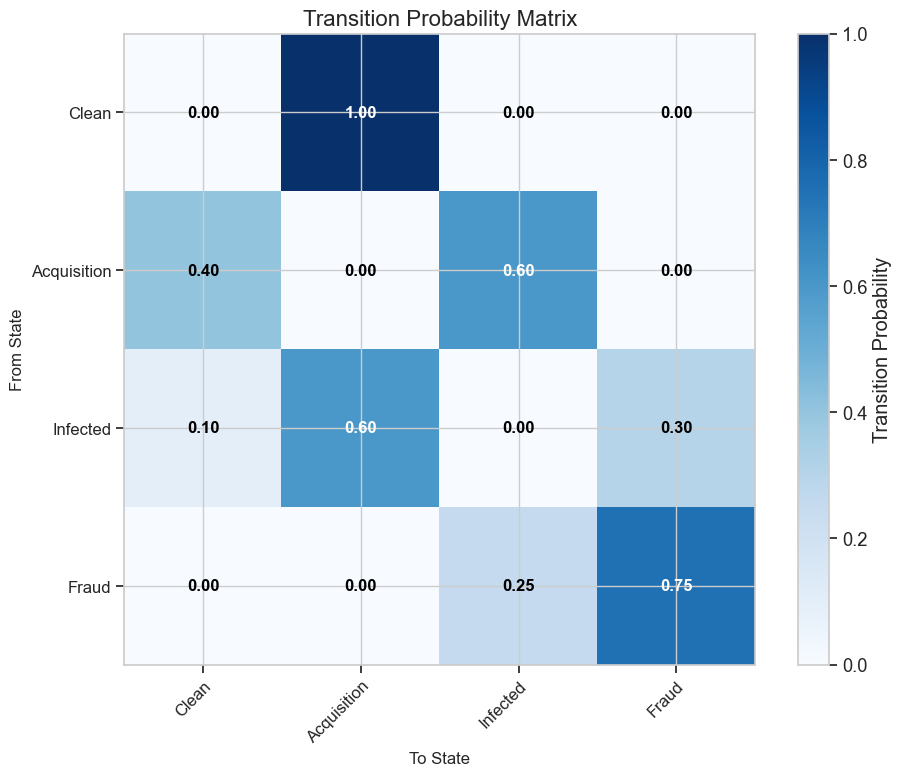

In [12]:
# Plot transition matrix
analyzer.plot_transition_matrix()

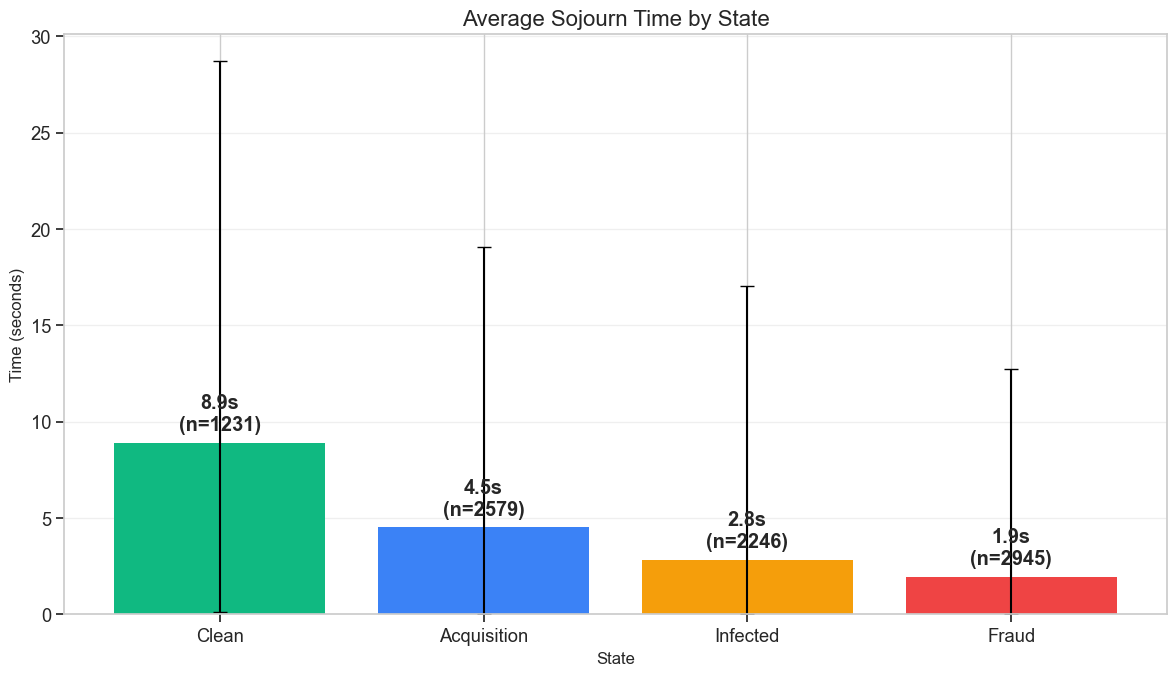

In [13]:
# Plot sojourn time analysis
analyzer.plot_sojourn_time_analysis()

In [14]:
# Display checkpoint cards
analyzer.display_checkpoint_cards()

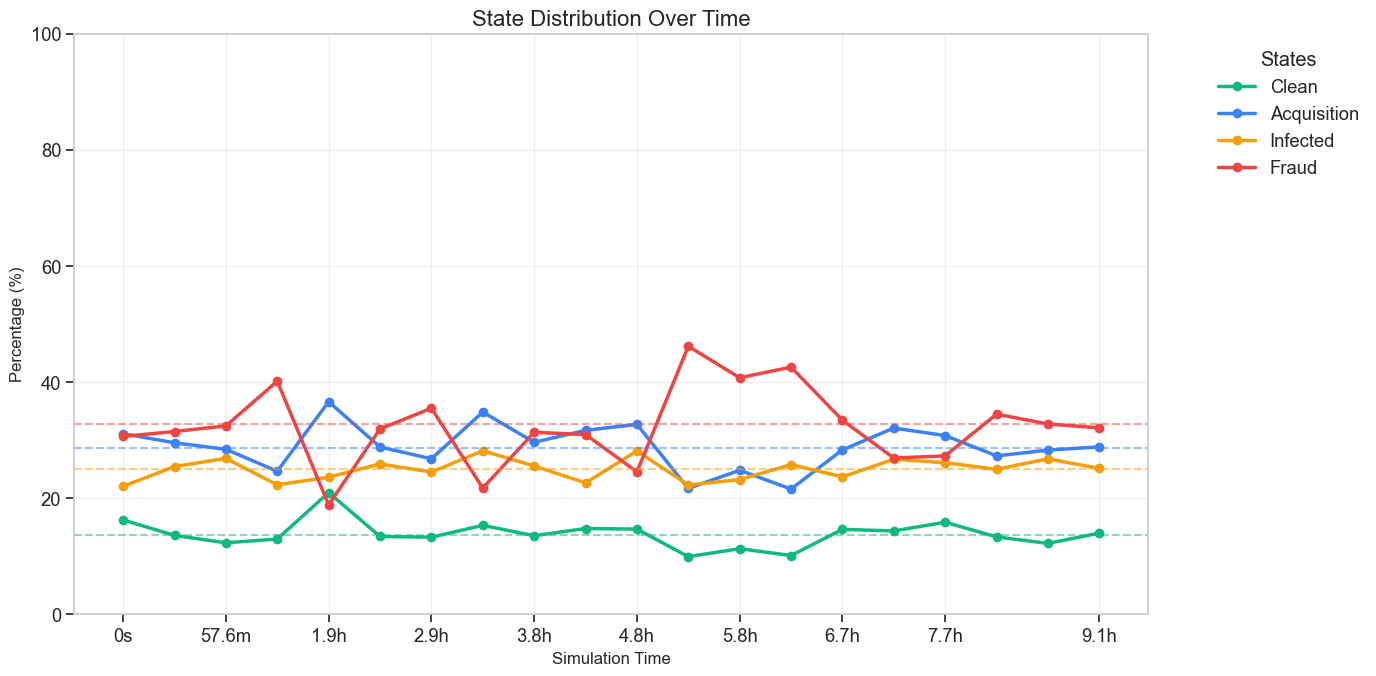

In [15]:
# Plot state distribution over time
analyzer.plot_state_distribution_over_time()

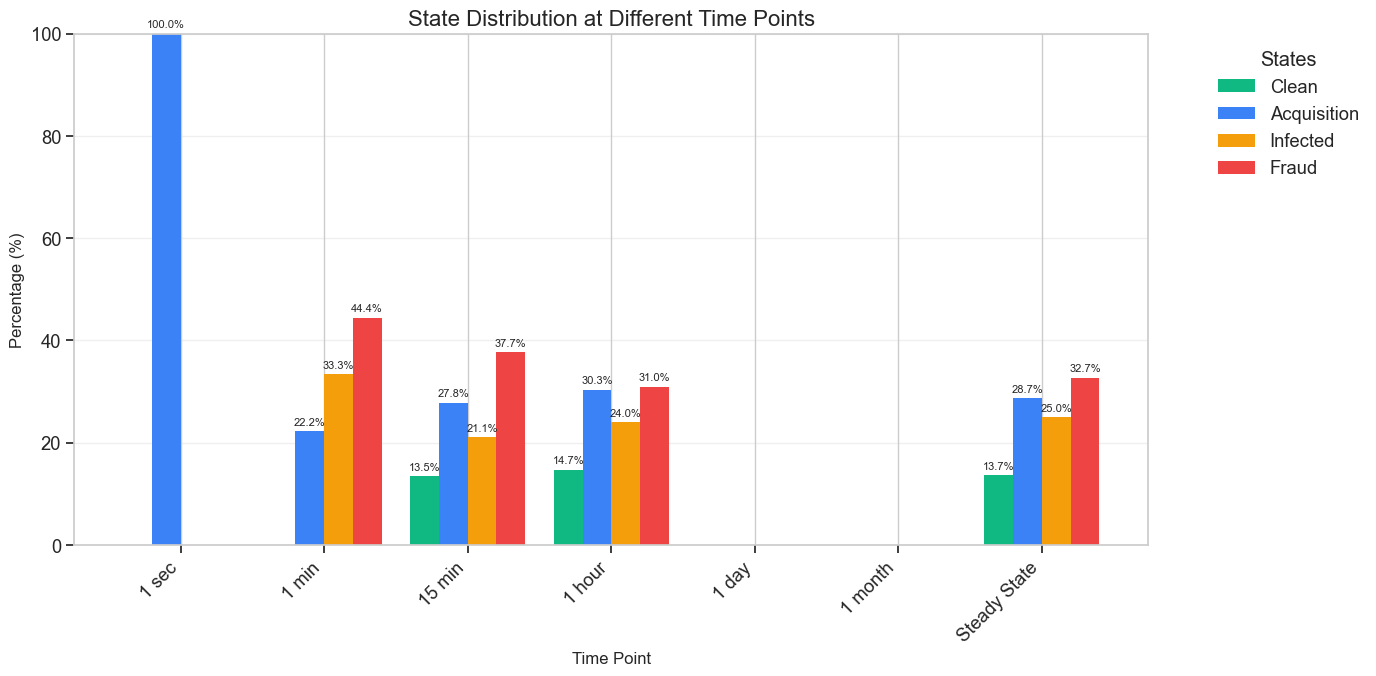

In [16]:
# Plot checkpoint distributions
analyzer.plot_checkpoint_distributions()